# Solving GLUE tasks using BERT

## What is the GLUE benchmark?

The General Language Undertanding Evaluation benchmark (GLUE) is collection of datasets used for training, evaluating and analyzing NLP models. The collection consists of nine difficult and diverse tasks datasets.

Dataset | Description | Data sample | Metric(s)  
--- | --- | --- | ---
CoLA | **Corpus of Linguistic Acceptability**<br>Is the sentence grammatically correct? | This building is than that one. <br> **= Ungrammatical** | Matthews
SST-2 | **Stanford Sentiment Treebank**<br>The task is to predict the sentiment of a given sentence. | The movie is funny, smart, and most of all alive.<br>**=.93056(very positive)** | Accuracy
MRPC | Microsoft Research Paraphrase Corpus<br>Determine whether a pair of sentences are semantically equivalent | a) Yesterday, Taiwan reported 35 new infections, briging the total number of cases to 418.<br>b) The island reported another 35 probable cases yesterday, taking its total to 418.<br>**A Paraphrase** | Accuracy/F1
QQP | **Quora Question Pairs2**<br>Are the two questions similar? | a) How to increase the speed of my internet connection while using a VPN?<br>b)How can Internet speed be increased by hacking through DNS?<br>**=Not similar** | Accuracy/F1
MNLI | **Multi-Genre Natural Language Inference**<br>Does sentence A entail or contradict sentence B?| a) Tourist information offices can be very helpful.<b>Tourist information offices are never of any help.<br>**=Contradiction** | Accuracy
WNLI | **Winograd Natural Language Inference**<br> Sentence B replaces sentence A's ambiguous pronoun with one of the nouns - is the corrent noun? | a) The thropy did not fit in the suitcase because it was too small.<br>b) The thropy did not fit in the suitcase because the suitcase was too small.<br>=Corrent Referent | Accuracy

##Setup the environment


In [1]:
#@title ###i. Install dependencies
#@markdown - tensorflow-text: text preprocessing
#@markdown - tf-models-official: pre-trained models hosted on tensorflow-hub
%%capture --no-stderr
!pip install -U pip
!pip install -Uqq tensorflow-text
!pip install -Uqq tf-models-official

In [2]:
#@title ###ii. Import packages
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text
from google.colab import data_table
from official.nlp import optimization
from tensorflow.config.experimental import list_physical_devices
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.preprocessing import text_dataset_from_directory

tf.get_logger().setLevel("ERROR")

print("tensorflow        ", tf.__version__)
print("tensorflow_hub    ", hub.__version__)
print("tensorflow_addons ", tfa.__version__)

tensorflow         2.4.0
tensorflow_hub     0.10.0
tensorflow_addons  0.8.3


In [3]:
#@title ###iii. Choose Accelerator Strategy
#@markdown Ideally you should run this notebook using a TPU. 
#@markdown In Colab, choose Runtime -> Change runtime type and verify that a 
#@markdown TPU is selected.
accelerator_strategy = "TPU" #@param ["TPU", "GPU", "None"]
#@markdown The TPU strategy requires to read checkpoints directly from
#@markdown TFHub's cloud storage bucket. It's recommended to setup a GCP
#@markdown bucket store the uncompressed checkpoints.
tfhub_model_load_format = "UNCOMPRESSED"  # @param ["UNCOMPRESSED", "GCP BUCKET"]
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = tfhub_model_load_format  # COLAB ONLY

tpu_address = os.environ.get("COLAB_TPU_ADDR", None)
#GCP TPU
#tpu_address = "Insert TPU address here"  # @param {type:"string"}

if tpu_address:
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
        tpu=f"grpc://{tpu_address}"
    )
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print("Using TPU")
    print("TPU devices: ", tf.config.list_logical_devices("TPU"))
elif tf.test.is_gpu_available():
    physical_gpus = list_physical_devices("GPU")
    logical_gpus = tf.config.experimental.list_logical_devices("GPU")
    print("Using GPU")
    print(
        len(physical_gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU"
    )
else:
    raise ValueError("Running on CPU is not recommended.")



Using TPU
TPU devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


## Game plan

1. Select a BERT model from the list of pre-trained models available. 
2. Load the selected model from Tensorflow Hub.
3. Choose a GLUE task to solve and download the associated dataset.
4. Preprocess the dataset text according to the task seleted.
5. Fine-tune BERT.
6. Save the trained .
7. Test the saved model with our reserved .

## 1. BERT models overview

Currently these is the family of BERT models available on Tensorflow Hub:

- `BERT-Base`, `Uncased` the original BERT models.
- `Small BERTs` maintain the original architecture but with fewer and/or smaller Transformer blocks.
- `ALBERT` reduces the model size by sharing parameters between layers. Doesn't improve processing times.
- `BERT Experts` offer a choice of domain specific pre-trained models.
- `Electra` gets trained as a discriminator from GANs. (A must try!)
- `BERT with talking-heads Attention` has improved the core of the Transformers architecture.

In [4]:
#@title ###Choose a BERT model to fine-tune
#@markdown You might want to start with a small model first `sm BERT uncased` 
#@markdown and then upgrader to a bigger model to improve accuracy.

bert_model_name = "sm BERT uncased" #@param ["sm BERT uncased", "albert", "sm electra", "talking heads"]

map_name_to_handle = {
    'sm BERT uncased':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'albert':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'sm electra':
        'https://tfhub.dev/google/electra_small/2',
    'talking heads':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'sm BERT uncased':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'albert':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'sm electra':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking heads':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


## 2. Preprocess the dataset

We will differenciate the preprocessing task in two stages.

- During training, where we will preprocess all the dataset as part of the input pipeline before feeding this data to our model. It's a good practice to keep the CPU busy preprocessing data while the GPU/TPU is processing a batch.
- During inference, we will merge the processing task to our saved model to keep a consistent input performing inferences.



In [5]:
#@title ###Testing text tokenization
text = "Preprocessing a dataset is fun!" #@param {type:"string"}
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant([text]))
print(tok)

<tf.RaggedTensor [[[17463, 3217, 9623, 7741], [1037], [2951, 13462], [2003], [4569], [999]]]>


In [6]:
#@title ###Packing inputs (padding, masking, and sentence id)
max_sequence_length = 20 #@param {type:"number"}

preprocessed_sentence = bert_preprocess.bert_pack_inputs(
    [tok, tok], tf.constant(max_sequence_length)
)

print(f"Keys       : {list(preprocessed_sentence.keys())}")
#@markdown `input_word_ids` token ids truncated to max_sequence_length.<br>
print(f"Shape      : {preprocessed_sentence['input_word_ids'].shape}")
print(f"Word Ids   : {preprocessed_sentence['input_word_ids'][0, :10]}")
#@markdown `input_mask` differenciates content from padding. 
print(f"Input Mask : {preprocessed_sentence['input_mask'][0, :10]}")
print(f"Type Ids   : {preprocessed_sentence['input_type_ids'][0, :100]}")

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 20)
Word Ids   : [  101 17463  3217  9623  7741  1037  2951 13462  2003  4569]
Input Mask : [1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]


BERT adds a "position embedding" to the token embedding of each input, and these come from a fixed-size lookup table. That imposes a max seq length of 512 (which is also a practival limit, due to quadratic growth of attention processing). We will default to 128.

In [7]:
MAX_SEQUENCE_LENGTH = 128


def make_bert_preprocess_model(
    sentence_features, seq_length=MAX_SEQUENCE_LENGTH
):
    """
    Packs string features in the format expected by BERT.

    Args:
        sentence_features: list with the names of string-values features.
        seq_lenght: defines the sequence length of BERT inputs.

    Returns:
        A Keras model that can be called on a list or dict of string Tensors
        and returns a dict of tensors for input to BERT.
    """
    input_segments = [
        Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features
    ]

    # tokenize the text to word pieces
    bert_preprocess = hub.load(tfhub_handle_preprocess)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # # optional: trim segments in a smart way to fit seq_length.
    # # simple cases: skip this step and let the next step apply a default
    # # truncation to approximate equal lengths.
    truncated_segments = segments

    # pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )

    model_inputs = packer(truncated_segments)
    return Model(input_segments, model_inputs)


Let's put our preprocessing model to the test.

In [30]:
text_preprocess_model = make_bert_preprocess_model(["my_input1", "my_input2"])
test_input = [
    np.array(["This is a very short text!"]),
    np.array(["Even shorter"]),
]
text_preprocessed = text_preprocess_model(test_input)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])

Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2023 2003 1037 2200 2460 3793  999  102 2130 7820  102    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0], shape=(16,), dtype=int32)


Let's take a look at the model's structure.

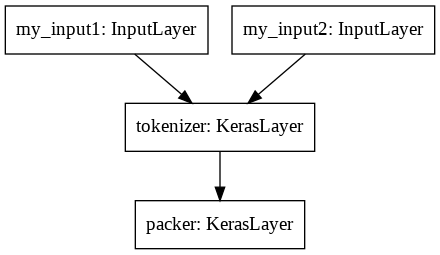

In [28]:
tf.keras.utils.plot_model(test_preprocess_model)

We will use `map` to apply the preprocessing to our entire dataset. The result is then cached for performance.

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


def load_dataset_from_tfds(
    in_memory_ds, info, split, batch_size, bert_preprocess_model
):
    is_training = split.startswith("train")
    dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
    num_samples = info.splits[split].num_examples

    if is_training:
        dataset = dataset.shuffle(num_samples)
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex["label"]))
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
    return dataset, num_samples

## 3. Define the Classification Model

GLUE processing model should be able to handle single or pair sentence classification. We will start with a simple model that process the sentence embeddings through BERT and perform the task classification using a linear dense layer. 

But, before defining our model, let's explore the encoder embeddings we expect to pass to the dense layer (`pooled_output`). 

In [36]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(preprocessed_sentence)

print(f"Loaded BERT          : {tfhub_handle_encoder}")
print(f"Model keys           : {list(bert_results.keys())}")
#@markdown `pooled_output` represents each input sentence as a whole. It's 
#@markdown equivalent to the embedding for the entire sentence.<br><br>
print(f"Pooled outputs shape : {bert_results["pooled_output"].shape}")
print(f"Pooled outputs values: {bert_results["pooled_output"][0,:5]}")

#@markdown `sequence_output` represents each input token in the context.
#@markdown Equivalent to the contextual embedding for every token in the 
#@markdown sentence.<br><br>
print(f"Sequence outputs shape : {bert_results["sequence_output"].shape}")
print(f"Pooled outputs values: {bert_results["sequence_output"][0,:5]}")

#@markdown `encoder_outputs` are the intermediate activations of the `L` 
#@markdown transformer blocks.<br><br>

#@markdown For fine tunning we will use the `pooled_output` array.<br><br>

Loaded BERT          : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Model keys           : ['encoder_outputs', 'sequence_output', 'default', 'pooled_output']
Pooled outputs shape : (1, 768)
Pooled outputs values: [-0.9931605  -0.908297   -0.99989605  0.9948193   0.9949657 ]
Sequence outputs shape : (1, 20, 768)
Pooled outputs values: [[-1.3826742  -0.09816195 -0.7705845  ... -0.5630569  -0.24293363
   0.73262954]
 [ 0.6490549  -0.4383925   0.12505011 ...  0.48145106  0.32823104
  -0.44533965]
 [-1.6090003  -1.0835725   0.15680218 ... -0.03220626 -0.52742815
  -0.56717074]
 [-0.12894651 -0.1555078  -0.23227423 ...  0.3682494  -0.46161163
  -0.33133852]
 [-1.0832301  -0.6357851  -0.14271829 ...  0.05782118 -0.24189152
  -0.14422521]]


In [37]:
def build_classifier_model(num_classes):
    inputs = dict(
        input_word_ids = Input(shape=(None,), dtype=tf.int32),
        input_mask = Input(shape=(None,), dtype=tf.int32),
        input_type_ids=Input(shape=(None,), dtype=tf.int32),
    )
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name="encoder")
    net = encoder(inputs)["pooled_output"]
    net = Dropout(rate=0.1)(net)
    net = Dense(num_classes, activation=None, name="classifier")(net)
    return Model(inputs, net, name="prediction")